# MLP

K = 4.
Normalized counts.   
One neuron.   

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-11-03 13:29:58.219006
Python 3.10.6
sklearn 1.1.2


In [2]:
import tensorflow as tf
dt = np.float32
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 
#from sklearn.model_selection import ShuffleSplit
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedKFold
#from sklearn.model_selection import StratifiedKFold
#import tensorflow as tf
#from tensorflow import keras
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
#from keras.layers import Bidirectional
from keras.layers import Dense
#from keras.layers import LayerNormalization
#from sklearn.preprocessing import StandardScaler
from keras.losses import BinaryCrossentropy
from sklearn.model_selection import KFold

from KmerCounter import KmerCounter
ALPHABET_SIZE=4
K=4
counter=KmerCounter(K)
VOCABULARY_SIZE = counter.get_vocabulary_size() 
print('K=',K,'alphabet size=',ALPHABET_SIZE,'vocabulary size=',VOCABULARY_SIZE)
from TrainValidSplit2 import Splitter2
EPOCHS=10
FOLDS=5
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

K= 4 alphabet size= 4 vocabulary size= 256


In [3]:
DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'
GENES_FILE = 'CNRCI_coding_train_genes.csv'
RCI_FILE = 'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE='CNRCI_coding_train_counts.K4.gc42.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    # Here is the joke model -- one neuron!
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=VOCABULARY_SIZE)
    layer2 = Dense(8, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    layer  = Dense(1, activation='sigmoid',dtype=dt,input_dim=VOCABULARY_SIZE)
    #mlp.add(layer1)
    #mlp.add(layer2)
    #mlp.add(output)
    mlp.add(layer)
      
    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-11-03 13:30:02.137558
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


## Load the data

In [7]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-11-03 13:30:02.222246
Num RCI: 10338
[('ENSG00000000003', 1.08068), ('ENSG00000000419', 1.32679), ('ENSG00000000457', 0.434284)]


In [8]:
# kmer counts
print(datetime.now())
print('Read kmer counts file')
filepath = DATA_DIR+COUNTS_FILE
labels=[]
allids=[]
counts=[]
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            gene_id = fields.pop(0)
            tran_id = fields.pop(0)
            numbers = [int(x) for x in fields]
            if gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                counts.append(numbers)
print(datetime.now())
print('Normalize')
rows = len(counts)
cols = len(counts[0])
for row in range(rows):
    total = sum(counts[row])
    for col in range(cols):
        counts[row][col] /= total
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(counts))
#print('Example:',counts[3])

2022-11-03 13:30:02.253461
Read kmer counts file
2022-11-03 13:30:04.544396
Normalize
2022-11-03 13:30:06.132871
Num IDs: 54251
Num labels: 54251
Num counts: 54251


In [9]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    return subsetX,subsetY

## Train and validate with all K-mer counts

In [10]:
SCALING = False
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,counts,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,counts,labels,0)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        fold += 1
        print('Fold',fold)
        print('Train sizes',len(X_train),len(y_train))
        print('Valid sizes',len(X_valid),len(y_valid))
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
    return cv_scores

2022-11-03 13:30:06.182210
2022-11-03 13:30:06.182210
splitting
Fold 1
Train sizes 43592 43592
Valid sizes 10659 10659
Train set ones/size 21682 / 43592
Valid set ones/size 5237 / 10659
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 13:30:06.213454
Epoch 1/10
1363/1363 [==============================] - 9s 6ms/step - loss: 0.6745 - accuracy: 0.6592 - val_loss: 0.6614 - val_accuracy: 0.6572
Epoch 2/10
1363/1363 [==============================] - 1s 980us/step - loss: 0.6474 - accuracy: 0.6793 - val_loss: 0.6431 - val_accuracy: 0.6580
Epoch 3/10
1363/1363 [==============================] - 1s 957us/step - loss: 0.6313 - accuracy: 0.6804 - val_loss: 0.6325 - val_accuracy: 0.6590
Epoch 4/10
1363/1363 [==============================] - 1s 985us/step - loss: 0.6217 - accuracy: 0.6812 - val_loss: 0.6266 - val_accuracy: 0.6592
Epoch 5/10
1363/1363 [==============================] - 1s 1ms/step - loss: 0.6159 - accuracy: 0.6815 - val_loss: 0.6232 - val_accuracy: 0.6596
Epoch 6/10
1363/1363 [

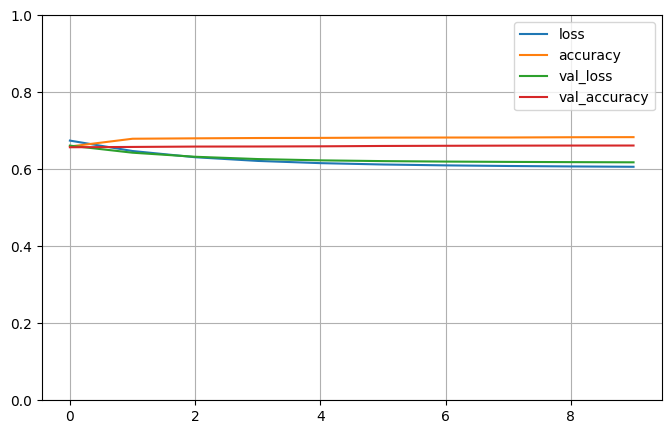

Compute valiation accuracy
2022-11-03 13:30:56.330039
accuracy: 66.17%
2022-11-03 13:31:03.744708
Fold 2
Train sizes 43443 43443
Valid sizes 10808 10808
Train set ones/size 21628 / 43443
Valid set ones/size 5291 / 10808
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 13:31:03.782491
Epoch 1/10
1358/1358 [==============================] - 9s 7ms/step - loss: 0.6752 - accuracy: 0.6559 - val_loss: 0.6600 - val_accuracy: 0.6765
Epoch 2/10
1358/1358 [==============================] - 1s 1ms/step - loss: 0.6484 - accuracy: 0.6745 - val_loss: 0.6401 - val_accuracy: 0.6763
Epoch 3/10
1358/1358 [==============================] - 2s 1ms/step - loss: 0.6324 - accuracy: 0.6759 - val_loss: 0.6286 - val_accuracy: 0.6762
Epoch 4/10
1358/1358 [==============================] - 1s 1ms/step - loss: 0.6228 - accuracy: 0.6769 - val_loss: 0.6220 - val_accuracy: 0.6766
Epoch 5/10
1358/1358 [==============================] - 1s 1ms/step - loss: 0.6172 - accuracy: 0.6776 - val_loss: 0.6182 - val_accuracy: 0

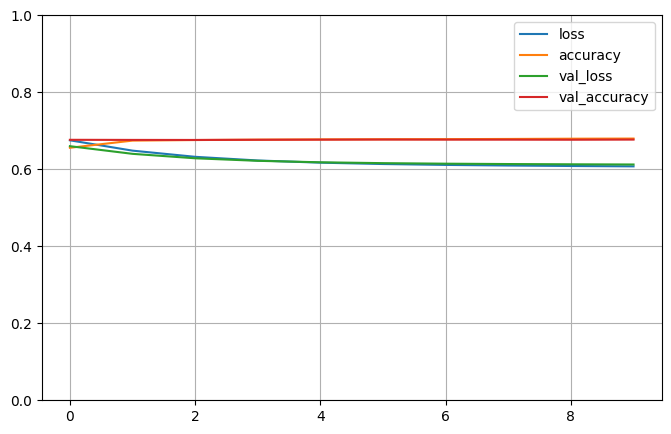

Compute valiation accuracy
2022-11-03 13:31:54.734330
accuracy: 67.71%
2022-11-03 13:32:02.158875
Fold 3
Train sizes 43240 43240
Valid sizes 11011 11011
Train set ones/size 21736 / 43240
Valid set ones/size 5183 / 11011
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 13:32:02.190122
Epoch 1/10
1352/1352 [==============================] - 9s 7ms/step - loss: 0.6752 - accuracy: 0.6643 - val_loss: 0.6609 - val_accuracy: 0.6814
Epoch 2/10
1352/1352 [==============================] - 1s 1ms/step - loss: 0.6491 - accuracy: 0.6749 - val_loss: 0.6414 - val_accuracy: 0.6817
Epoch 3/10
1352/1352 [==============================] - 1s 1ms/step - loss: 0.6333 - accuracy: 0.6753 - val_loss: 0.6297 - val_accuracy: 0.6834
Epoch 4/10
1352/1352 [==============================] - 2s 1ms/step - loss: 0.6238 - accuracy: 0.6759 - val_loss: 0.6228 - val_accuracy: 0.6835
Epoch 5/10
1352/1352 [==============================] - 1s 1ms/step - loss: 0.6181 - accuracy: 0.6767 - val_loss: 0.6187 - val_accuracy: 0

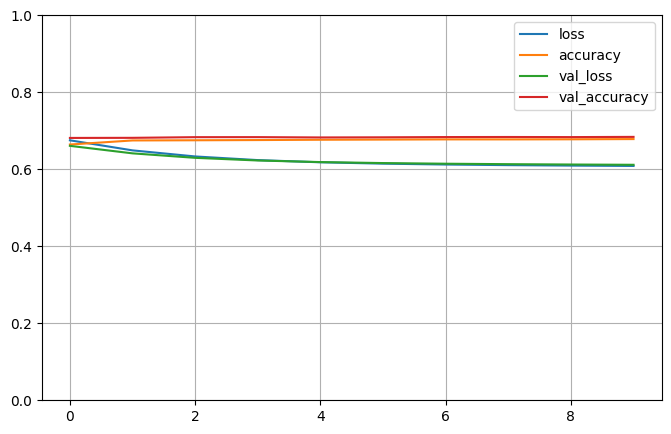

Compute valiation accuracy
2022-11-03 13:32:52.507110
accuracy: 68.41%
2022-11-03 13:33:00.550700
Fold 4
Train sizes 43345 43345
Valid sizes 10906 10906
Train set ones/size 21265 / 43345
Valid set ones/size 5654 / 10906
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 13:33:00.581964
Epoch 1/10
1355/1355 [==============================] - 9s 7ms/step - loss: 0.6750 - accuracy: 0.6506 - val_loss: 0.6601 - val_accuracy: 0.6628
Epoch 2/10
1355/1355 [==============================] - 1s 1ms/step - loss: 0.6488 - accuracy: 0.6736 - val_loss: 0.6397 - val_accuracy: 0.6665
Epoch 3/10
1355/1355 [==============================] - 1s 1ms/step - loss: 0.6332 - accuracy: 0.6756 - val_loss: 0.6275 - val_accuracy: 0.6689
Epoch 4/10
1355/1355 [==============================] - 1s 1ms/step - loss: 0.6240 - accuracy: 0.6765 - val_loss: 0.6201 - val_accuracy: 0.6701
Epoch 5/10
1355/1355 [==============================] - 2s 1ms/step - loss: 0.6186 - accuracy: 0.6775 - val_loss: 0.6156 - val_accuracy: 0

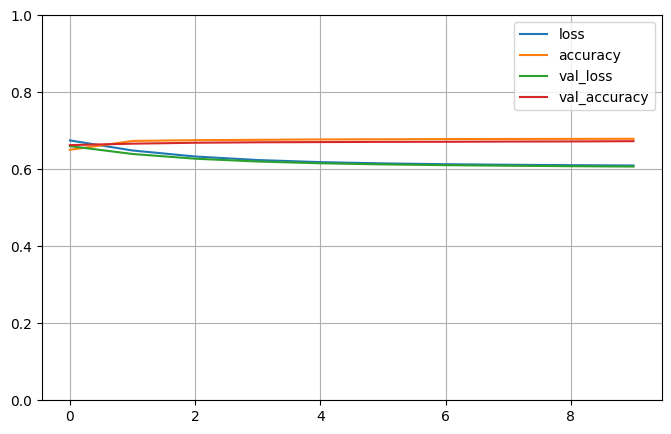

Compute valiation accuracy
2022-11-03 13:33:50.772758
accuracy: 67.30%
2022-11-03 13:33:59.476685
Fold 5
Train sizes 43384 43384
Valid sizes 10867 10867
Train set ones/size 21365 / 43384
Valid set ones/size 5554 / 10867
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 13:33:59.514982
Epoch 1/10
1356/1356 [==============================] - 9s 7ms/step - loss: 0.6762 - accuracy: 0.6404 - val_loss: 0.6584 - val_accuracy: 0.6878
Epoch 2/10
1356/1356 [==============================] - 1s 1ms/step - loss: 0.6505 - accuracy: 0.6669 - val_loss: 0.6362 - val_accuracy: 0.6920
Epoch 3/10
1356/1356 [==============================] - 1s 1ms/step - loss: 0.6351 - accuracy: 0.6693 - val_loss: 0.6227 - val_accuracy: 0.6931
Epoch 4/10
1356/1356 [==============================] - 1s 1ms/step - loss: 0.6259 - accuracy: 0.6707 - val_loss: 0.6144 - val_accuracy: 0.6934
Epoch 5/10
1356/1356 [==============================] - 1s 1ms/step - loss: 0.6205 - accuracy: 0.6713 - val_loss: 0.6093 - val_accuracy: 0

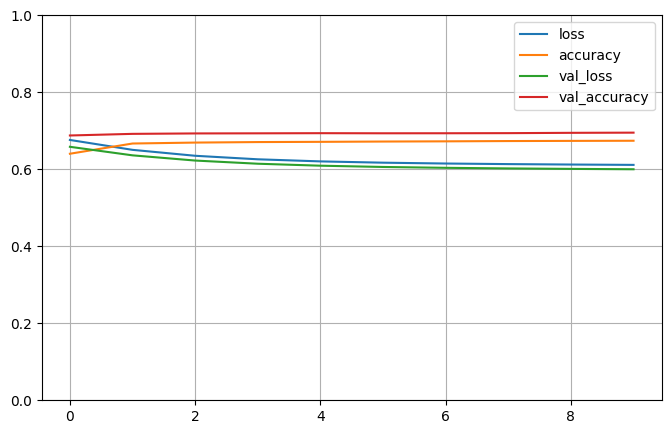

Compute valiation accuracy
2022-11-03 13:34:49.894952
accuracy: 69.51%
2022-11-03 13:34:58.985993
Cross validation acc mean 67.82% (+/- 1.12%)
2022-11-03 13:34:58.985993


In [11]:
print(datetime.now())
cv_scores = do_cross_validation(EPOCHS)    
print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
print(datetime.now())